# Anomaly Detection in Sklearn

<b> Methods </b>: 
1. DBSCAN
2. Isolation Forests 
3. One-Class SVM
4. Elliptic Envelope
5. Local Outlier Factor

<b> Recommendations </b>:
1. Use grid search for parameter values like contamination.
2. IF is better than EE for high dimensional datasets (source 1)
3. EE needs a lot of data points: n^2/ for n features


In [230]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
%matplotlib inline
import os as os
import matplotlib
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
plt.rcParams['figure.figsize'] = 9,7
import warnings
warnings.filterwarnings('ignore')
print('This file is located in the following directory: \n'+os.getcwd())

This file is located in the following directory: 
/Users/Work/Desktop/Work/Projects/2019


In [2]:
data=pd.read_csv('/Users/Work/Desktop/Work/Projects/Datasets/Mall_Customers.csv')
data.head(2)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81


In [134]:
data=data.drop('CustomerID',axis=1)
data=data.rename(columns={
                    'Annual Income (k$)':'Income',
                    'Spending Score (1-100)':'Spend_Score'})
num=data.iloc[:,1:5]

Some sources on anomaly detection: <br>
1. http://sdsawtelle.github.io/blog/output/week9-anomaly-andrew-ng-machine-learning-with-python.html

# Multivariate Outlier Detection Algorithms

##  DBSCAN Clustering Algorithm 
DBSCAN - Density-Based Spatial Clustering of Applications with Noise

DBSCAN is a clustering algorithm (like K-means) that clusters points together based on the distances between them.  Unlike K-means, the number of clusters does not need to be specified in advance.  It automatically determines the number of clusters.  Also, if a point is too far away from other points, DBSCAN doesn't group it into a cluster and assigns it a value of -1.

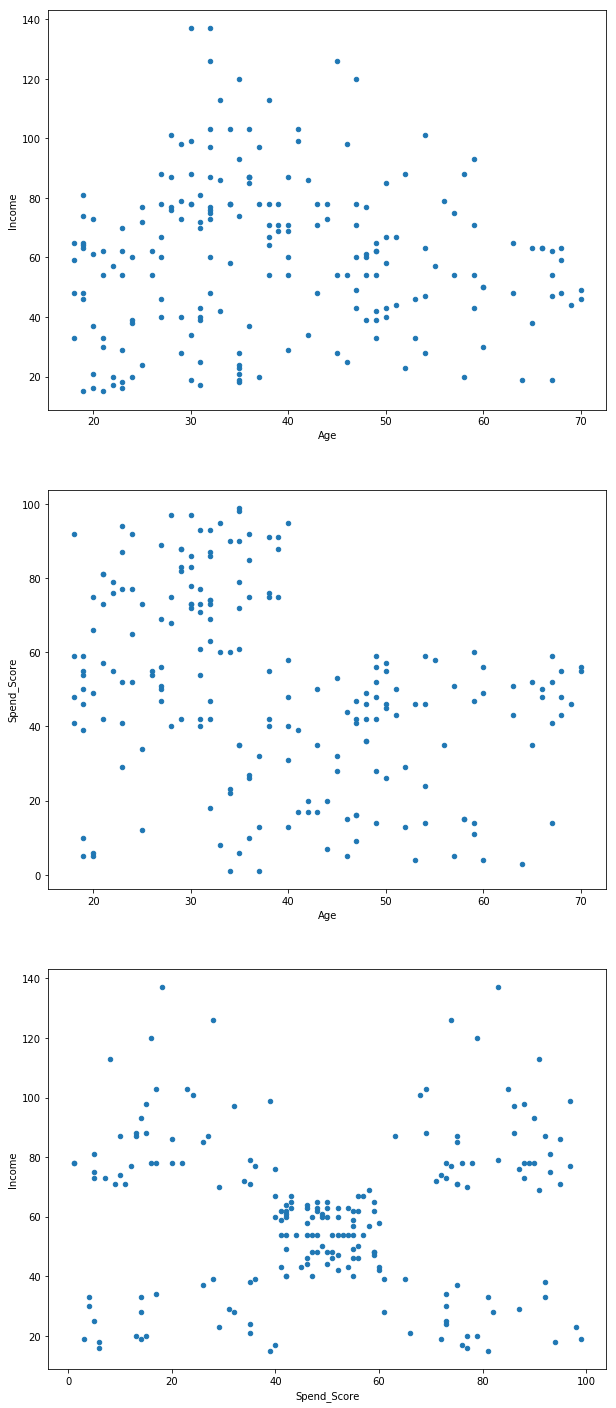

In [48]:
fig, axes = plt.subplots(3,1, figsize=(10,25 ))
data.plot.scatter(x='Age',y='Income',ax=axes[0])
data.plot.scatter(x=7'Age',y='Spend_Score',ax=axes[1])
data.plot.scatter(x='Spend_Score',y='Income',ax=axes[2])

Do we see any multivariate outliers above?  Notice some low ages have high incomes and some low ages have high spend scores.  The 3rd plot has 4 clusters of points outside the main cluster, but calling them outliers wouldn't be right, since too many points seem to systematically lie within each group.

In running the DBSCAN algorithm,  I selected epsilon through a process of trial-and-error.  6 outliers were generated at an epsilon of .2, while over 200 outliers were generated at a value of .3, and zero were generated at higher values.

In [149]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() #scale variables for clustering algorithm
num2 = scaler.fit_transform(num)
num2 = pd.DataFrame(num2, columns = num.columns)

from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
    eps = .2, #this epsilon was selected through trial and error
    metric="euclidean", #default
    min_samples = 5, #default
    n_jobs = -1)

clusters = outlier_detection.fit_predict(num2)
clusters[:5]

array([-1,  0, -1,  0,  0])

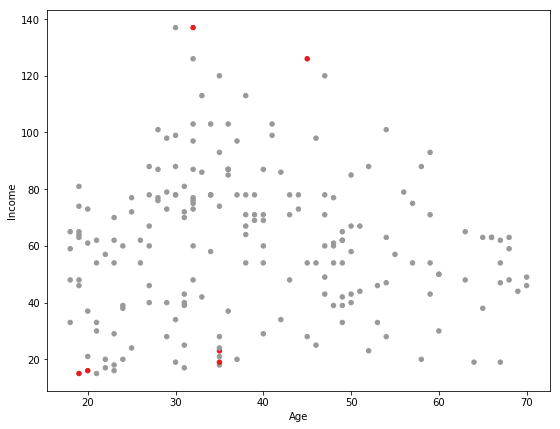

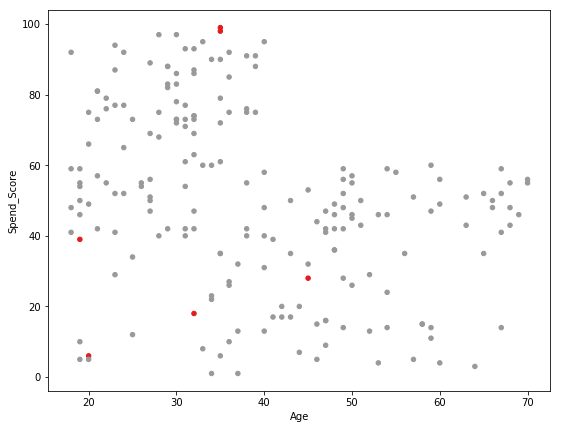

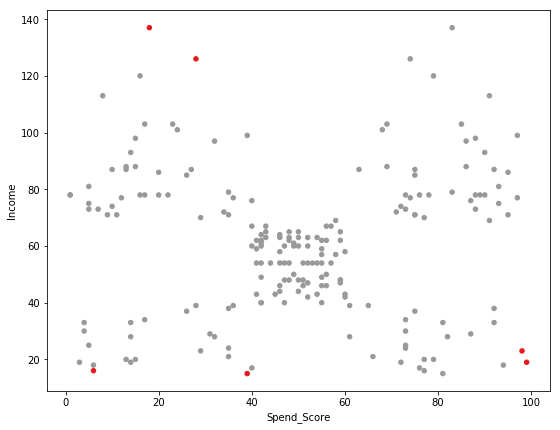

In [150]:
from matplotlib import cm
cmap = cm.get_cmap('Set1')
num.plot.scatter(x='Age',y='Income', c=clusters, cmap=cmap,
                colorbar = False)
num.plot.scatter(x='Age',y='Spend_Score', c=clusters, cmap=cmap,
                colorbar = False)
num.plot.scatter(x='Spend_Score',y='Income', c=clusters, cmap=cmap,
                colorbar = False)

DBSCAN works as follows:


Lingo: <br>
1.  Any point that has at least min_samples points within eps (epsilon) distance of it will form a cluster.  This point is called a core point.  The core point will itself count towards the min_samples requirement. 
2.  Any point within eps distance of a core point, but does not have min_samples points that are within eps distance of itself is called a borderline point and does not form its own cluster.  
3.  A border point that is within eps distance of multiple core points (multiple epsilon balls) will arbitrarily end up in just one of these resultant clusters.
4.  Any point that is randomly selected that is not found to be a core point or a borderline point is called a noise point or outlier and is not assigned to any cluster (does not contain at least min_samples points that are eps distance from it or is not within eps distance of a core point).
5.  The epsilon-neighborhood of point p is all points within epsilon distance of p, which are said to be directly reachable from p.
6. A point contained in the neighborhood of a point directly reachable from p is not directly reachable, but is density-reachable.
7. Any point that can be reached by jumping from neighborhood to neighborhood from the original core point is density-reachable.

Algorithm: <br>
1. Randomly select a point not already assigned to a cluster or designated as an outlier and determine if it's a core point by seeing if there are at least min_samples points around it within eps distance.  
2. Create a cluster of this core point and all points within epsilon distance of it (all directly reachable points).
3. Find all points that are within epsilon distance of each point in the cluster and add them to the cluster.  Find all points that are within epsilon distance of all newly added points and add these to the cluster. Rinse and repeat.  (Perform "neighborhood jumps" to find all density-reachable points and add them to the cluster).

Source that inspired above code: <br>
https://mikulskibartosz.name/outlier-detection-with-scikit-learn-d9246b33d352  <br>
Sources that inspired explanation of DBSCAN: <br>
https://blog.dominodatalab.com/topology-and-density-based-clustering/
http://mccormickml.com/2016/11/08/dbscan-clustering/
https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/
https://www.quora.com/How-does-DBSCAN-algorithm-work
https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80
https://medium.com/@elutins/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818
https://medium.com/@soroush.hashemi76/kmeans-vs-dbscan-d9d5f9dbee8b

## Isolation Forests

<b> How it works: </b> <br> 
 1. Select a sample
 2. Select a feature randomly and select a value in its range randomly.
 3.  If the sample's value falls above this value, make this value the new minimum for the feature.  If it falls below, make this value the new maximum for the feature.
 4.  Check if any other samples have values in the range of all features, where some ranges were altered via step 3.  If yes, then the sample is isolated.  
 5. Repeat steps 3 & 4.  The number of times you had to go through these steps is the isolation number.  The lower the number, the more anomalous the sample is.
 

Explanation 2: <br>
For each observation, generates an anomaly score or isolation number.

1.  Randomly selects a feature and randomly selects a value in that feature's range which splits that feature.
2. If the data point's feature value falls above (below) the split value, then the split value becomes the new mimimum (maximum) of that feature's range.  
3.  Repeat the above steps until no other point has selected feature values within the modified ranges of those features.

<b> sklearn.ensemble.IsolationForest </b> <br>

<i>Contamination</i> is the proportion of the data that you want to identify as outliers or that you believe are outliers (it'll take the top x% of examples with the highest isolation numbers) <br>
<i>n_estimators</i> is the number of decision trees in the forest. <br>
<i>max_features </i> is the number of variables that are used to define outliers on.  Just use default, which is all of your features.
<br>
<i> max_samples</i> is the number of samples to draw while building a single tree. <br>
<i>decision_function </i> returns avg anomaly score; lower scores = more abnormal; range = [-.5,.5] <br>
<i>fit_predict </i> fits on data and predicts labels <br>
<i>predict </i> predicts labels (-1 indicates anomaly, 1 doesn't), labels whose decision\_function anomaly score < clf.threshold_, which model calculates are classified as anomalous


There is a newer version of the algorithm called Extended Isolation Forests.

links: <br>
https://www.depends-on-the-definition.com/detecting-network-attacks-with-isolation-forests/ <br>
https://stackoverflow.com/questions/45223921/what-is-the-range-of-scikit-learns-isolationforest-decision-function-scores <br>
https://quantdare.com/isolation-forest-algorithm/

In [116]:
from sklearn.ensemble import IsolationForest
import numpy as np
rs=np.random.RandomState(0)
clf = IsolationForest(max_samples=100,random_state=rs,
                     contamination=.1) #defaults
clf.fit(num)
if_scores = clf.decision_function(num)
if_anomalies=clf.predict(num)
if_anomalies=pd.Series(y_pred_if).replace([-1,1],[1,0])
if_anomalies=num[if_anomalies==1];

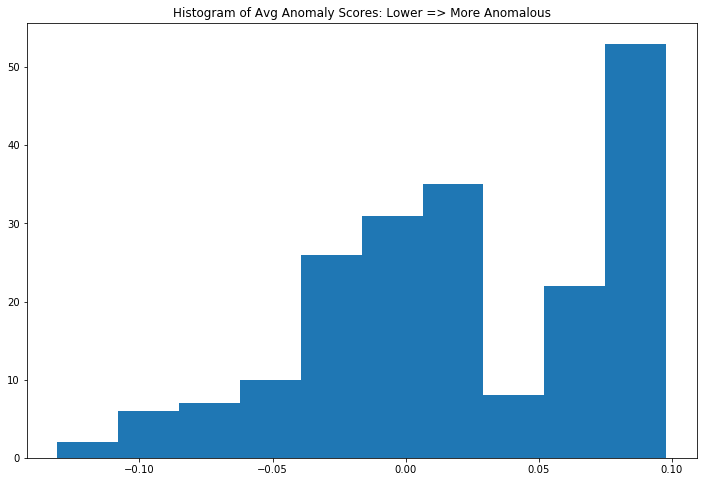

In [61]:
plt.figure(figsize=(12,8))
plt.hist(if_scores);
plt.title('Histogram of Avg Anomaly Scores: Lower => More Anomalous');

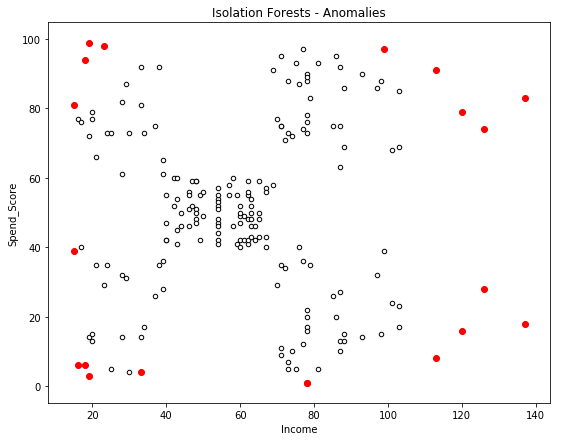

In [180]:
cmap=np.array(['white','red'])
plt.scatter(num.iloc[:,1],num.iloc[:,2],c='white',s=20,edgecolor='k')
plt.scatter(if_anomalies.iloc[:,0],if_anomalies.iloc[:,1],c='red')
plt.xlabel('Income')
plt.ylabel('Spend_Score')
plt.title('Isolation Forests - Anomalies')

## One-Class Support Vector Machines

<i> Nu </i> seems to be like the contamination parameter in other methods and determines the % of observations the algorithm will identify as outliers.

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.001, kernel='rbf',
      max_iter=-1, nu=0.2, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

 1    162
-1     38
dtype: int64

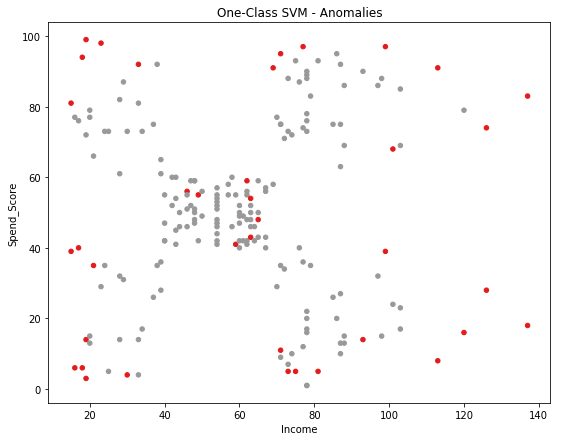

In [200]:
from sklearn import svm
cmap = cm.get_cmap('Set1')
clf=svm.OneClassSVM(nu=.2,kernel='rbf',gamma=.001)
df=pd.get_dummies(data)
clf.fit(df)
y_pred=clf.predict(df)
pd.Series(y_pred).value_counts()
num.plot.scatter(x='Income',y='Spend_Score', c=y_pred, cmap=cmap,
                colorbar = False)
plt.title('One-Class SVM - Anomalies')

## Projection Methods

PCA, Robust PCA, SOM, Sammon's mapping

1. Summarize feature space to 2 dimensions
2. Visualize the features and identify outliers by hand
   OR use proximity measures / codebook vectors to identify outliers

# EllipticEnvelope

EllipticEnvelope predicts any observation as an anomaly as having a fitted density below the xth percentile fitted density where x=specified contamination value.  <br>

In [256]:
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import normalize, scale
df_stan=pd.DataFrame(scale(df))
clf = EllipticEnvelope(contamination=.1,random_state=0)
clf.fit(df_stan)
ee_scores = pd.Series(clf.decision_function(df_stan)) #fit densities
ee_predict = clf.predict(df_stan) #-1 indicates an outlier, 1 doesn't

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=0,
         store_precision=True, support_fraction=None)

In [249]:
ee_scores.min(),ee_scores.max()

(-0.54627939270765546, 0.99061859312170442)

In [250]:
threshold = stats.scoreatpercentile(clf.decision_function(df_stan),
                                    100*.1)
threshold

3.6118268645656849e-06

Notice below that outliers seem to be assigned negative fitted densities.

In [251]:
clf.threshold_
np.array(ee_scores[:10])
ee_predict[:10]

7.8304308053098293

array([-0.02101093, -0.03266575, -0.21264633,  0.13632229,  0.34428536,
        0.14919461,  0.06633206, -0.01282581, -0.0332388 ,  0.28361188])

array([-1, -1, -1,  1,  1,  1,  1, -1, -1,  1])

In [260]:
ee_predict2=pd.Series(ee_predict).replace([-1,1],[1,0])
ee_anomalies=df[ee_predict2==1]
len(ee_anomalies)

20

In [53]:
from scipy import stats
y_pred = clf.predict(df_stan)
threshold=stats.scoreatpercentile(scores_pred,100*.25)
z = clf.decision_function()

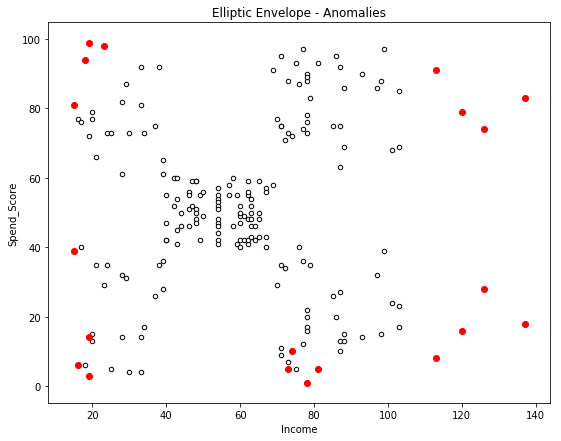

In [263]:
cmap=np.array(['white','red'])
plt.scatter(num.iloc[:,1],num.iloc[:,2],c='white',s=20,edgecolor='k')
plt.scatter(ee_anomalies.iloc[:,1],ee_anomalies.iloc[:,2],c='red')
           #,marker='x',s=100)
plt.title('Elliptic Envelope - Anomalies')
plt.xlabel('Income')
plt.ylabel('Spend_Score')

# Local Outlier Factor

If LOF > 1 , then this indicates the density of the point is smaller than that of its neighbors.  Sklearn outputs the negative of LOF scores and labels any above a certain threshold as anomalies via the predict method.

<b> How it works: </b>

Uses density-based outlier detection to identify local outliers, points that are outliers with respect to their local neighborhood, rather than with respect to the global data distribution.  

This is great because other methods like proximity-based clustering won't identify a point that's an outlier relative to a nearby cluster of points (a local outlier) if that whole region is not an outlying region in the global space of data points.

A point is labeled an outlier if the density around that point is significantly different from the density around its neighbors.

<b>The method, step-by-step </b>
1. Calculate distances between each pair of points (manhattan = |x1-x2| + |y1-y2|) = dist(p1,p2)
2. For each point P, find the Kth closest point (Kth nearest neighbor = K-Dist(P))
3. For each point P, find the K closest points (those whose distances are smaller than the Kth point), the K-distance neighborhood of P, Nk(P).
4. For each point P, find its density (LRDk(p) - a measure of how close its neighbors are to it), basically the inverse of the avg distance between point p and its neighbors (the lower the density, the farther p is from its neighbors)
5. For each point P, find its local outlier factor, LOFk(p), as sum(densities of its neighbors) x sum(reachability distances of its neighbors to P).

LOFk(P) is the total distance between P and its neighboring points, weighted by those points' densities (how far they are from their k neighboring points).  

<b>Scenarios</b>: <br>
High value if--> P is far from its neighbors and its neighbors have high densities (are close to their neighbors) <br>
Less high value if -> P is far from its neighbors, but its neighbors have low densities <br>
Less high value if -> P is close to its neighbors and its neighbors have low densities

<b>Adjusting K (from observing the below plots) </b>
- Increase K too much and you're just looking for outliers wrt the global data space, so points far away from the highest density regions could be misclassified as outliers, even though they themselves reside in a cluster of points
- Reduce K too much and you're looking for outliers wrt to very small local data spaces.  LOF might not vary enough and may be too high for many points, even those in high density regions.  Points that aren't outliers could be misclassified as outliers even though they lie in high density regions.

<b> Details </b> <br>
\*\*For step 2, If 2 points have the same distance to P, then just select one as the next closest, and the other as the next next closest.  <br>
\*\*For step 4, LRD = Local Reachability Density = inverse(avg reachability distance between P and its neighbors) <= 1.  The word reachability is used because if a neighbor is closer to P than it's Kth neighbor, then the distance of the Kth neighbor is used instead as a means of smoothing <br>
\*\*For step 4, each reachability distance of a point p's k neighbors  is reachdistk(n1<-p) = max(distk(n1), dist(n1,p)) <br>
\*\*For step 4, total distances of neighboring points divided by the number of neighboring points (or ||Nk(P)||), computed using the results of step 3

<b>In the below graphic </b>: <br>LOF is great at assigning a high value to points like O1 and O2, which are local outliers to cluster C1, whose points have high densities.  <br>LOF(O1) = (high densities for neighbors) x (high distances of neighbors from O1) = high value

<img src="Images/example.png",width=500, height=100>

# LOF results for increasing K 

In [ ]:
df=df.drop('ID',axis=1)

In [182]:
def LOF_plot(k):
    import seaborn as sns
    from sklearn.neighbors import LocalOutlierFactor
    var1,var2=1,2
    clf = LocalOutlierFactor(n_neighbors=k, contamination=.1)
    y_pred = clf.fit_predict(df)
    LOF_Scores = clf.negative_outlier_factor_
    
    plt.title("Local Outlier Factor (LOF), K={}".format(k))
    plt.scatter(df.iloc[:, var1], df.iloc[:, var2], color='k', s=3., label='Data points')
    # plot circles with radius proportional to the outlier scores
    radius = (LOF_Scores.max() - LOF_Scores) / (LOF_Scores.max() - LOF_Scores.min())
    plt.scatter(df.iloc[:, var1], df.iloc[:, var2], s=1000 * radius, edgecolors='r',
                facecolors='none', label='Outlier scores')
    plt.axis('tight')
    plt.ylabel("{}".format(df.columns[var1]))
    plt.xlabel("{}".format(df.columns[var2]))
    legend = plt.legend(loc='upper left')
    legend.legendHandles[0]._sizes = [10]
    legend.legendHandles[1]._sizes = [20]
    plt.show();

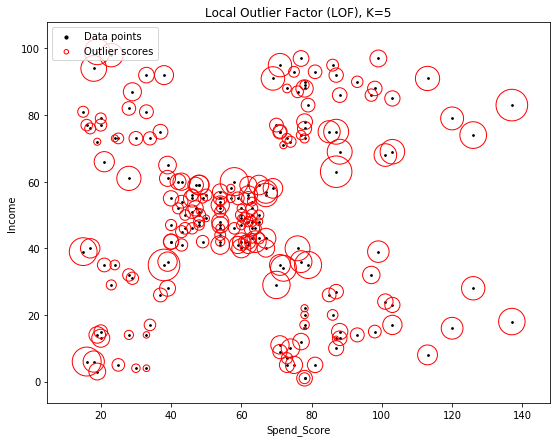

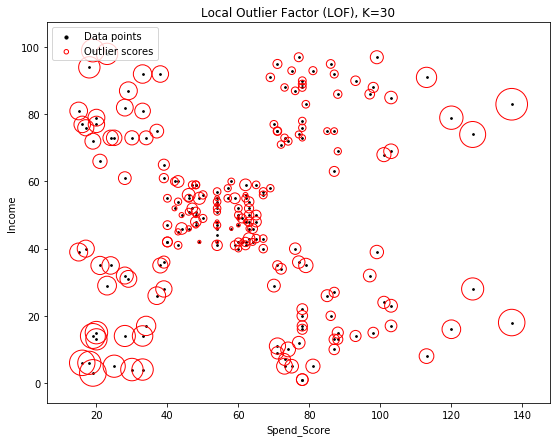

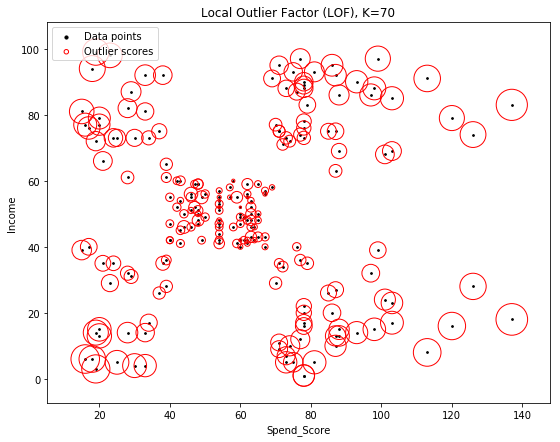

In [189]:
LOF_plot(5)
LOF_plot(30)
LOF_plot(70)

From the above, I will select k=30, which doesn't appear to assign as many points large LOF factors (by having smaller red circles).

In [172]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=30, contamination=.1)
y_pred = clf.fit_predict(df) #outputs -1 as anomaly, 1 as regular
LOF_Scores = clf.negative_outlier_factor_

clf.threshold_ #threshold LOF Scores is -1.29 (the negative of LOF)
LOF_Scores[:10] 
y_pred[:10] #notice anything below -1.29 is labeled as an anomaly
LOF_pred=pd.Series(y_pred).replace([-1,1],[1,0])
LOF_anomalies=df[LOF_pred==1]

-1.2914884357606309

array([-1.24151246, -1.23175005, -1.53962229, -1.19568636, -1.21317087,
       -1.1849605 , -1.43837196, -1.36366778, -1.59608449, -1.17707551])

array([ 1,  1, -1,  1,  1,  1, -1, -1, -1,  1])

Observe the below plot of LOF anomalies using K=30.

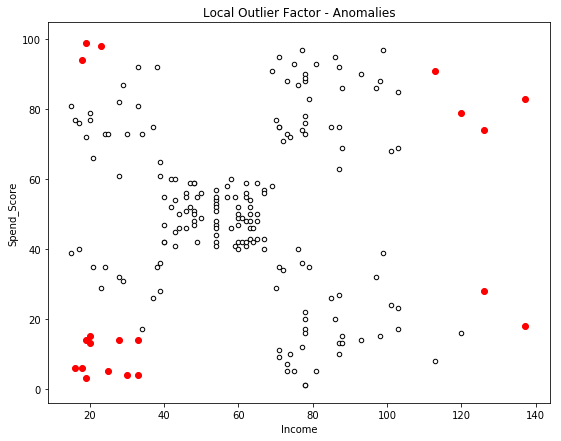

In [211]:
cmap=np.array(['white','red'])
plt.scatter(num.iloc[:,1],num.iloc[:,2],c='white',s=20,edgecolor='k')
plt.scatter(LOF_anomalies.iloc[:,1],LOF_anomalies.iloc[:,2],c='red')
           #,marker='x',s=100)
plt.title('Local Outlier Factor - Anomalies')
plt.xlabel('Income')
plt.ylabel('Spend_Score')